## Non-linear

In [413]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import multivariate_normal as mvn

In [414]:
N = 100
dt = 0.1
q1, q2 = 1, 1
s1, s2 = 0.5, 0.5

Q = np.array([[(q1 * dt**3) / 3, 0, (q1 * dt**2) / 2, 0],
              [ 0, (q2 * dt**3) / 3, 0, (q2 * dt**2) / 2],
              [(q1 * dt**2) / 2, 0, q1 * dt, 0],
              [0, (q2 * dt**2) / 2, 0, q2 * dt]])

R = np.array([[s1, 0],
              [0, s2]])

A = np.array([[1, 0, dt, 0],
             [0, 1, 0, dt],
             [0, 0, 1, 0],
             [0, 0, 0, 1]])

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

# Nonlinear state transition function
def f_linear(x):
    return A @ x

def f_nonlinear(x):
    return np.array([0.1 * np.sin(x[0]), 0.1 * np.sin(x[1]), 0, 0])

def f(x):
    return f_linear(x) + f_nonlinear(x)

# Nonlinear observation function
def h_linear(x):
    return H @ x

def h_nonlinear(x):
    return np.array([1.0 * np.sin(x[1]), -1.0 * np.cos(x[0])])

def h(x):
    return h_linear(x) + h_nonlinear(x)

# Jacobians of the state transition and observation functions
def F_jacobian(x):
    return np.array([[1 + 0.1 * np.cos(x[0]), 0, dt, 0],
                    [0, 1 + 0.1 * np.cos(x[1]), 0, dt],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])

def H_jacobian(x):
    return np.array([[1, 1.0 * np.cos(x[1]), 0, 0],
                     [1.0 * np.sin(x[0]), 1, 0, 0]])

# Generate data with nonlinear true path and nonlinear observations
x = np.array([0, 0, 1, 1])
true_trajectory = [x]
noisy_observations = [h(x)[:2]]

for _ in range(N):
    x = f(x) + mvn([0, 0, 0, 0], Q)
    y = h(x) + mvn([0, 0], R)

    true_trajectory.append(x)
    noisy_observations.append(y)

true_trajectory = np.array(true_trajectory)
noisy_observations = np.array(noisy_observations)

In [415]:
P = np.eye(4)
m = true_trajectory[0]
estimated_trajectory_KF = []
Ps_KF = []

for y in noisy_observations:
    m_pred = A @ m
    P_pred = A @ P @ A.T + Q
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    m = m_pred + K @ (y - H @ m_pred)
    P = P_pred - K @ S @ K.T
    
    estimated_trajectory_KF.append(m)
    Ps_KF.append(P)

Ps_KF = np.array(Ps_KF)
estimated_trajectory_KF = np.array(estimated_trajectory_KF)

# RTS Smoother
n, dim_x = estimated_trajectory_KF.shape

estimated_trajectory_RTS, Ps_KF_RTS = estimated_trajectory_KF.copy(), Ps_KF.copy()

for k in range(n-2,-1,-1):
    P_pred = A @ Ps_KF_RTS[k] @ A.T + Q

    G = Ps_KF_RTS[k] @ A.T @ np.linalg.inv(P_pred)
    estimated_trajectory_RTS[k] += G @ (estimated_trajectory_RTS[k+1] - A @ estimated_trajectory_RTS[k])
    Ps_KF_RTS[k] += G @ (Ps_KF_RTS[k+1] - P_pred) @ G.T

In [416]:
# Implement the EKF with nonlinear true path and nonlinear observations
from filterpy.kalman import ExtendedKalmanFilter

# Define the EKF object
ekf = ExtendedKalmanFilter(dim_x=4, dim_z=2)

# Define the EKF functions
ekf.x = true_trajectory[0]
ekf.F = F_jacobian(ekf.x)
ekf.Q = Q
ekf.R = R
ekf.P = np.eye(4)*0.1

# Apply the EKF to the noisy observations
estimated_trajectory_EKF_builtin, Ps_EKF = [], []

for y in noisy_observations:
    ekf.predict()
    ekf.update(y, H_jacobian, h)
    estimated_trajectory_EKF_builtin.append(ekf.x)
    Ps_EKF.append(ekf.P)

estimated_trajectory_EKF_builtin = np.array(estimated_trajectory_EKF_builtin)
Ps_EKF = np.array(Ps_EKF)

In [417]:
# from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
# from filterpy.kalman import JulierSigmaPoints

# def f_new(x, dt):
#     return np.array([x[0] + dt * x[2] + 0.1 * np.sin(x[0]), x[1] + dt * x[3] + 0.1 * np.sin(x[1]), 0, 0])

# #points = MerweScaledSigmaPoints(4, alpha=.1, beta=2., kappa=-1)
# sigmas = JulierSigmaPoints(n=4, kappa=1)
# kf = UnscentedKalmanFilter(dim_x=4, dim_z=2, dt=dt, fx=f_new, hx=h, points=sigmas)
# kf.x = true_trajectory[0]
# kf.R = R
# kf.Q = Q

# estimated_trajectory_UKF_builtin = [kf.x]
# Ps = [kf.P]

# for measurement in noisy_observations:
#     kf.predict()
#     kf.update(measurement)
#     estimated_trajectory_UKF_builtin.append(kf.x)
#     Ps.append(kf.P)

# estimated_trajectory_UKF_builtin = np.array(estimated_trajectory_UKF_builtin)
# Ps = np.array(Ps)

from pykalman import UnscentedKalmanFilter

def f_noise(x, noise):
    return f(x) + noise

def h_noise(x, noise):
    return h(x) + noise

# Initialize the Unscented Kalman Filter
ukf = UnscentedKalmanFilter(initial_state_mean = true_trajectory[0],
                            initial_state_covariance = np.eye(4),
                            transition_functions = (f_noise, f_linear),
                            observation_functions = (h_noise, h_linear),
                            transition_covariance = Q,
                            observation_covariance = R)

# Apply the UKF to the noisy observations
estimated_trajectory_UKF_builtin, Ps_UKF = ukf.filter(noisy_observations)
estimated_trajectory_UKF_RTS_builtin, Ps_UKF_RTS = ukf.smooth(noisy_observations)

# Convert the results to numpy arrays
estimated_trajectory_UKF_builtin = np.array(estimated_trajectory_UKF_builtin)
estimated_trajectory_UKF_RTS_builtin = np.array(estimated_trajectory_UKF_RTS_builtin)
Ps_UKF = np.array(Ps_UKF)
Ps_UKF_RTS = np.array(Ps_UKF_RTS)

In [418]:
from matplotlib.patches import Ellipse
from scipy.linalg import eigh
from scipy.stats import chi2

cornflowerblue_alpha = (0.39215686274509803, 0.5843137254901961, 0.9294117647058824, 0.3)

def rgba_to_rgb(rgba, bg=(1, 1, 1)):
    r, g, b, a = rgba
    bg_r, bg_g, bg_b = bg
    
    # Blend the RGBA color with the background color
    r = r * a + bg_r * (1 - a)
    g = g * a + bg_g * (1 - a)
    b = b * a + bg_b * (1 - a)

    return (r, g, b)

def conf_ellipse(ax, center, covariance, alpha=0.90):
    chi2_quantile = chi2.ppf(alpha, 2)
    eigvals, eigvecs = eigh(covariance)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigvals[0] * chi2_quantile), 2 * np.sqrt(eigvals[1] * chi2_quantile)
    ell = Ellipse(xy=center, width=width, height=height, angle=angle, fill=True, facecolor=rgba_to_rgb(cornflowerblue_alpha))
    ax.add_artist(ell)

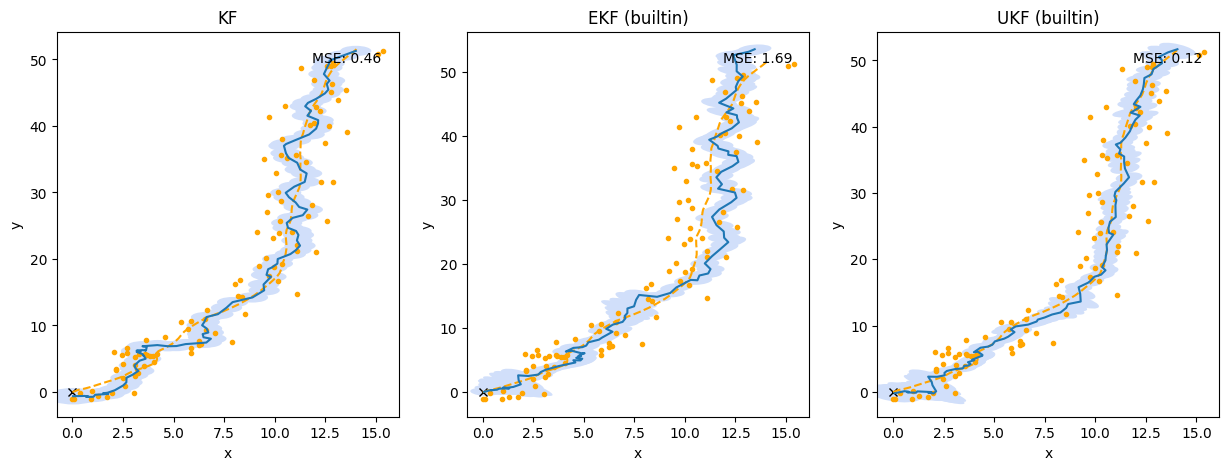

In [419]:
#Compare methods
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for k in range(3):
    ax[k].plot(true_trajectory[0, 0], true_trajectory[0, 1], 'x', color='k', label="Start")
    ax[k].plot(true_trajectory[:, 0], true_trajectory[:, 1], '--', color='orange', label="True trajectory")
    ax[k].plot(noisy_observations[:, 0], noisy_observations[:, 1], '.', color='orange', label="Noisy observations")
    ax[k].set_xlabel("x")
    ax[k].set_ylabel("y")
    
ax[0].plot(estimated_trajectory_KF[:, 0], estimated_trajectory_KF[:, 1], label="KF")  
ax[0].set_title("KF")
 
ax[1].plot(estimated_trajectory_EKF_builtin[:, 0], estimated_trajectory_EKF_builtin[:, 1], label="EKF (builtin)")
ax[1].set_title("EKF (builtin)")

#ax[2].plot(estimated_trajectory_UKF_builtin[:, 0], estimated_trajectory_UKF_builtin[:, 1], label="UKF (builtin)")
ax[2].plot(estimated_trajectory_UKF_builtin[:, 0], estimated_trajectory_UKF_builtin[:, 1], label="UKF (builtin 2)")
ax[2].set_title("UKF (builtin)")

# Compute MSE
KF_MSE = np.mean((true_trajectory[:, :2] - estimated_trajectory_KF[:, :2])**2)
EKF_MSE = np.mean((true_trajectory[:, :2] - estimated_trajectory_EKF_builtin[:, :2])**2)
UKF_MSE = np.mean((true_trajectory[:, :2] - estimated_trajectory_UKF_builtin[:, :2])**2)

# Show the MSE on the plot in upper right corner
ax[0].text(0.95, 0.95, "MSE: {:.2f}".format(KF_MSE), horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, "MSE: {:.2f}".format(EKF_MSE), horizontalalignment='right', verticalalignment='top', transform=ax[1].transAxes)
ax[2].text(0.95, 0.95, "MSE: {:.2f}".format(UKF_MSE), horizontalalignment='right', verticalalignment='top', transform=ax[2].transAxes)

# # 95% confidence ellipses for the KF
for i in range(0, len(estimated_trajectory_KF)):
    conf_ellipse(ax[0], estimated_trajectory_KF[i, :2], Ps_KF[i, :2, :2])
    
# # 95% confidence ellipses for the EKF
for i in range(0, len(estimated_trajectory_EKF_builtin)):
    conf_ellipse(ax[1], estimated_trajectory_EKF_builtin[i, :2], Ps_EKF[i, :2, :2])
    
# # 95% confidence ellipses for the UKF
for i in range(0, len(estimated_trajectory_UKF_builtin)):
    conf_ellipse(ax[2], estimated_trajectory_UKF_builtin[i, :2], Ps_UKF[i, :2, :2])   

plt.show()

[]

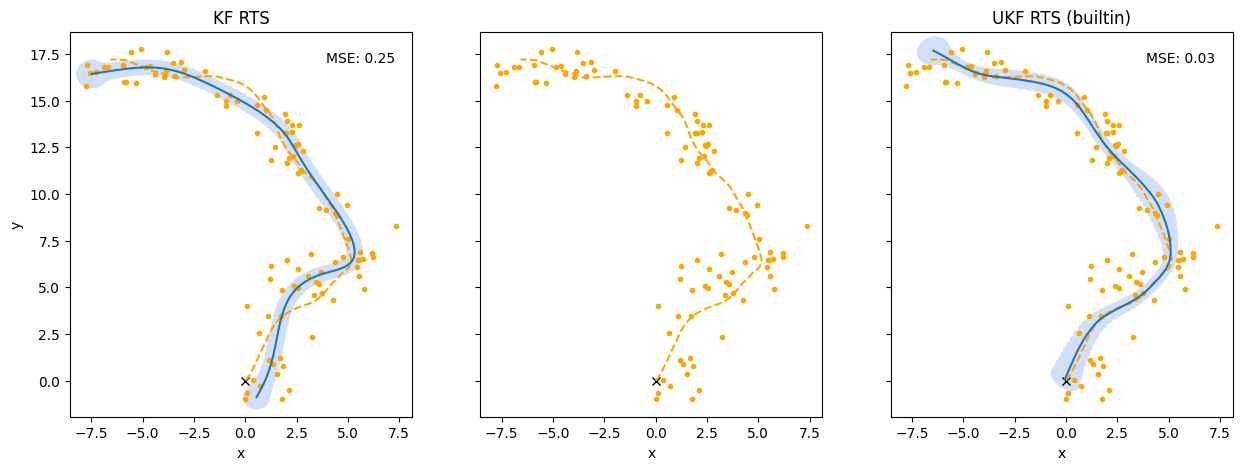

In [412]:
#Compare methods
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

ax[0].set_ylabel("y")
for k in range(3):
    ax[k].plot(true_trajectory[0, 0], true_trajectory[0, 1], 'x', color='k', label="Start")
    ax[k].plot(true_trajectory[:, 0], true_trajectory[:, 1], '--', color='orange', label="True trajectory")
    ax[k].plot(noisy_observations[:, 0], noisy_observations[:, 1], '.', color='orange', label="Noisy observations")
    ax[k].set_xlabel("x")
    
ax[0].plot(estimated_trajectory_RTS[:, 0], estimated_trajectory_RTS[:, 1], label="KF RTS")
ax[0].set_title("KF RTS")
 
# ax[1].plot(estimated_trajectory_EKF_builtin[:, 0], estimated_trajectory_EKF_builtin[:, 1], label="EKF (builtin)")
# ax[1].set_title("EKF (builtin)")

ax[2].plot(estimated_trajectory_UKF_RTS_builtin[:, 0], estimated_trajectory_UKF_RTS_builtin[:, 1], label="UKF RTS (builtin)")
ax[2].set_title("UKF RTS (builtin)")

# Compute MSE
KF_RTS_MSE = np.mean((true_trajectory[:, :2] - estimated_trajectory_RTS[:, :2])**2)
# EKF_MSE = np.mean((true_trajectory[:2] - estimated_trajectory_EKF_builtin[:2])**2)
UKF_RTS_MSE = np.mean((true_trajectory[:, :2] - estimated_trajectory_UKF_RTS_builtin[:, :2])**2)

# Show the MSE on the plot in upper right corner
ax[0].text(0.95, 0.95, "MSE: {:.2f}".format(KF_RTS_MSE), horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)
# ax[1].text(0.95, 0.95, "MSE: {:.2f}".format(EKF_MSE), horizontalalignment='right', verticalalignment='top', transform=ax[1].transAxes)
ax[2].text(0.95, 0.95, "MSE: {:.2f}".format(UKF_RTS_MSE), horizontalalignment='right', verticalalignment='top', transform=ax[2].transAxes)

# 95% confidence ellipses for the KF RTS
for i in range(0, len(estimated_trajectory_RTS)):
    conf_ellipse(ax[0], estimated_trajectory_RTS[i, :2], Ps_KF_RTS[i, :2, :2])

# 95% confidence ellipses for the UKF RTS
for i in range(0, len(estimated_trajectory_UKF_RTS_builtin)):
    conf_ellipse(ax[2], estimated_trajectory_UKF_RTS_builtin[i, :2], Ps_UKF_RTS[i, :2, :2])
    
plt.plot()


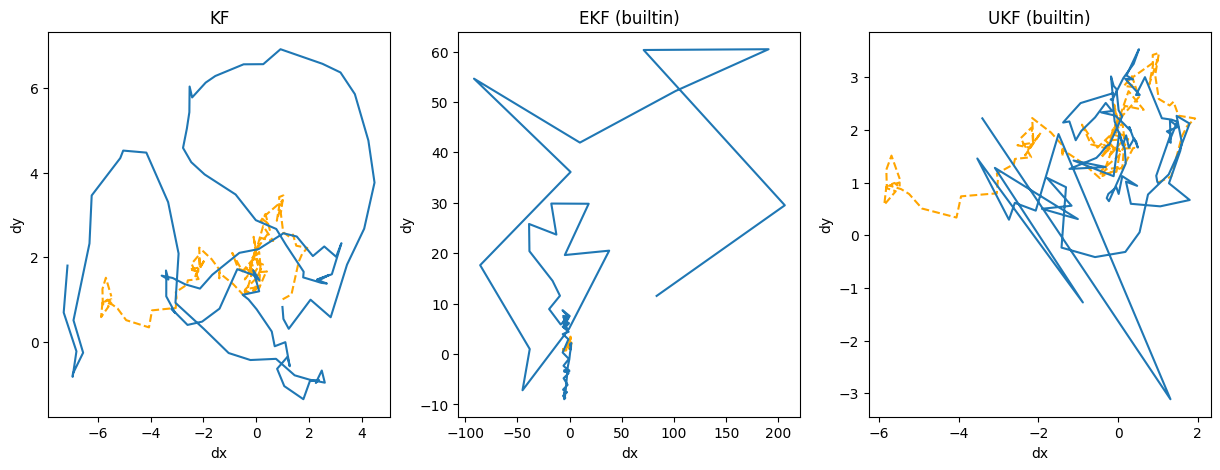

In [253]:
#Compare methods
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for k in range(3):
    ax[k].plot(true_trajectory[:, 2], true_trajectory[:, 3], '--', color='orange', label="True trajectory")
    ax[k].set_xlabel("dx")
    ax[k].set_ylabel("dy")
    
ax[0].plot(estimated_trajectory_KF[:, 2], estimated_trajectory_KF[:, 3], label="KF")  
ax[0].set_title("KF")
 
ax[1].plot(estimated_trajectory_EKF_builtin[:, 2], estimated_trajectory_EKF_builtin[:, 3], label="EKF (builtin)")
ax[1].set_title("EKF (builtin)")

ax[2].plot(estimated_trajectory_UKF_builtin[:, 2], estimated_trajectory_UKF_builtin[:, 3], label="UKF (builtin)")
ax[2].set_title("UKF (builtin)")
   
plt.show()
